In [1]:
# Run
# Vehicle detection project

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
%matplotlib inline
import os
import glob
from skimage.feature import hog
# import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label


Your function returned a count of 8792  cars and 8968  non-cars
END processing...... Sat Apr 22 16:59:39 2017


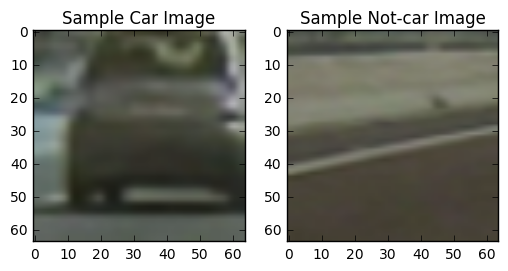

In [2]:
# Run
#Load car and not car data from files provided in the resources.
# Data exploration
cars = []
notcars = []


car_paths = ['Vehicles/GTI_Far', 'Vehicles/GTI_Left', 'Vehicles/GTI_Right', 'Vehicles/GTI_MiddleClose', 'Vehicles/KITTI_extracted']        
for path in car_paths:
    path_new = os.path.join(path,"*.png")
    for infile in glob.glob(path_new):
            cars.append(infile)

notcar_paths = ['Non_Vehicles/GTI', 'Non_Vehicles/Extras']        
for path in notcar_paths:
    path_new = os.path.join(path,"*.png")
    for infile in glob.glob(path_new):
            notcars.append(infile)
            
    
# count 

print('Your function returned a count of', 
      len(cars), ' cars and', 
      len(notcars), ' non-cars')

# read one cars and one no cars image 

car_image = cv2.imread(cars[50])
notcar_image = cv2.imread(notcars[50])

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Sample Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Sample Not-car Image')

print("END processing......", time.strftime("%c"))

In [3]:
# Run
# Define all functions

# feature extraction functions
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    """
    Returns HOG features and optionally, visualization,
    from an image using the sklearn library
    """

    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    fhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range) #First channel histogram
    shist = np.histogram(img[:,:,1], bins=nbins, range=bins_range) # Second channel histogram
    thist = np.histogram(img[:,:,2], bins=nbins, range=bins_range) # Third channel histogram
    # Generating bin centers
    bin_edges = fhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((fhist[0], shist[0], thist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, fhist, shist, thist, bin_centers

def bin_spatial_features(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


print("END processing......", time.strftime("%c"))

END processing...... Sat Apr 22 16:59:51 2017


END processing...... Sat Apr 22 16:59:58 2017


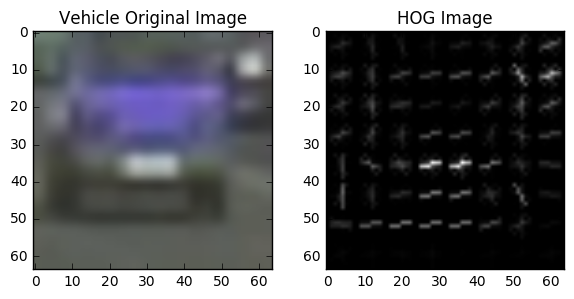

In [4]:
# visualize HOG features


orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# visualize HOG features of vehicle
image_1 = cv2.imread(cars[120])
gray_image = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)

# HOG Feature
features, hog_image = get_hog_features(gray_image, orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block,vis=True, feature_vec=True)

# display results
f, (ax1, ax2) = plt.subplots(1, 2) #, figsize=(12, 5)
f.tight_layout()

ax1.imshow(image_1, cmap='gray')
ax1.set_title('Vehicle Original Image') # , fontsize=30
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Image')

print("END processing......", time.strftime("%c"))

END processing...... Sat Apr 22 17:00:10 2017


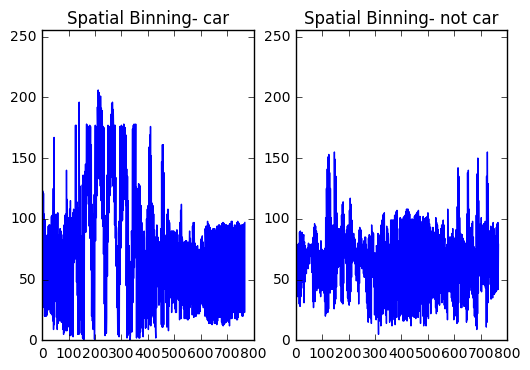

In [5]:

#Look at color features
#Spatial binned features comparison for car and notcar

def bin_spatial(img, color_space='RGB', size=(16, 16)): 
    if color_space!= 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    resize = cv2.resize(feature_image, size)
    features = resize.ravel()
    
    # Return the feature vector
    return features


car_image = cv2.imread(cars[120])
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)

notcar_image = cv2.imread(notcars[120])
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_BGR2RGB)

car_image_s = bin_spatial(car_image, color_space='HSV', size=(16, 16))
notcar_image_s = bin_spatial(notcar_image, color_space='HSV', size=(16, 16))


# Plot features
plt.figure(figsize=(20,20))
fig = plt.figure()
a=fig.add_subplot(121)
plt.plot(car_image_s)
a.set_ylim([0, 255])
a.set_title('Spatial Binning- car')

a=fig.add_subplot(122)
plt.plot(notcar_image_s)
a.set_ylim([0, 255])
a.set_title('Spatial Binning- not car')

print("END processing......", time.strftime("%c"))


In [6]:
# Define a function to extract features from a list of images
def extract_features_c(imgs, cspace='HLS',spatial_size=(16, 16),
                        hist_bins=16, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RGB color space
        
        spatial_features = bin_spatial(image, color_space=cspace, size= spatial_size)
        hist_features = color_hist_features(image, nbins=hist_bins, bins_range=hist_range)
    
        features.append(np.concatenate((spatial_features, hist_features)))

        
    return features

car_features_color = extract_features_c(cars, cspace='RGB', spatial_size=(16, 16), hist_bins=32, hist_range=(0, 256))

notcar_features_color = extract_features_c(notcars, cspace='RGB', spatial_size=(16, 16), hist_bins=32, hist_range=(0, 256))

print("car features color: ", len(car_features_color))

print("not car features color:", len(notcar_features_color))

print("END processing......", time.strftime("%c"))

car features color:  8792
not car features color: 8968
END processing...... Sat Apr 22 17:00:33 2017


END processing...... Sat Apr 22 17:00:51 2017


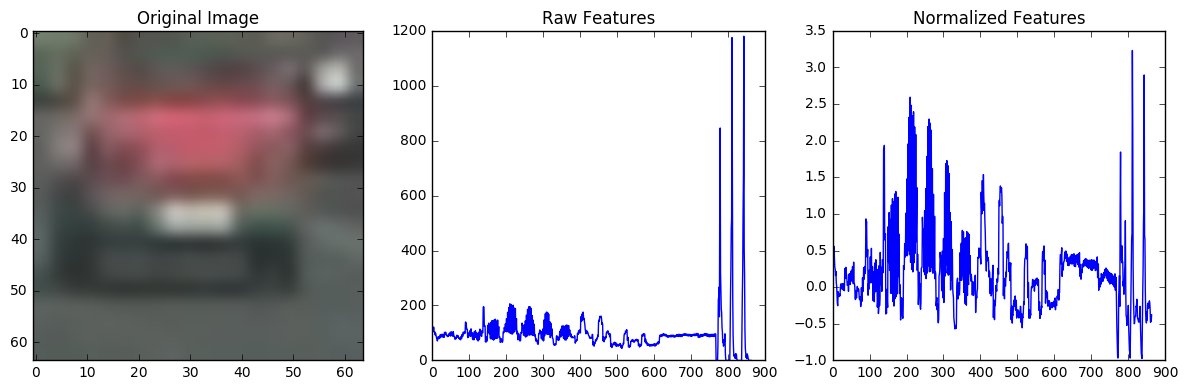

In [7]:
# create an array stack, apply scalar
from sklearn.preprocessing import StandardScaler
if len(car_features_color) > 0:
    # Create an array stack of feature vectors
    X_color = np.vstack((car_features_color, notcar_features_color)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_color)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X_color)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[120]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X_color[120])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[120])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')
    
print("END processing......", time.strftime("%c"))

In [8]:
# Run
# Return list of features for the image
def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RGB color space
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial_features(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist_features(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

print("END processing......", time.strftime("%c"))

END processing...... Sat Apr 22 17:00:59 2017


In [9]:
# Run
# Train classifier using HOG and color features

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from sklearn.cross_validation import train_test_split

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell #16
cell_per_block = 1 # HOG cells per block #2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, None] # Min and max in y to search in slide_window()

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

print("END processing......", time.strftime("%c"))

56.1 Seconds to extract HOG features...
Using: 9 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 432
1.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9747
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  1.  0.]
0.0 Seconds to predict 10 labels with SVC
END processing...... Sat Apr 22 17:02:05 2017


In [10]:
# Run
#extract features from test images

def single_img_features(img, color_space='HSV', spatial_size=(16, 16), 
                        hist_bins=16, orient=6, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=2,
                        spatial_feat=False, hist_feat=False, hog_feat=True): 
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Spatial Features
    if spatial_feat == True:
        spatial_features = bin_spatial_features(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Histogram features
    if hist_feat == True:
        hist_features = color_hist_features(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Hog Features
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

##Sliding window implementation
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

print("END processing......", time.strftime("%c"))

END processing...... Sat Apr 22 17:02:22 2017


In [11]:
# Run
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

print("END processing......", time.strftime("%c"))

END processing...... Sat Apr 22 17:02:29 2017


END processing...... Sat Apr 22 17:02:42 2017


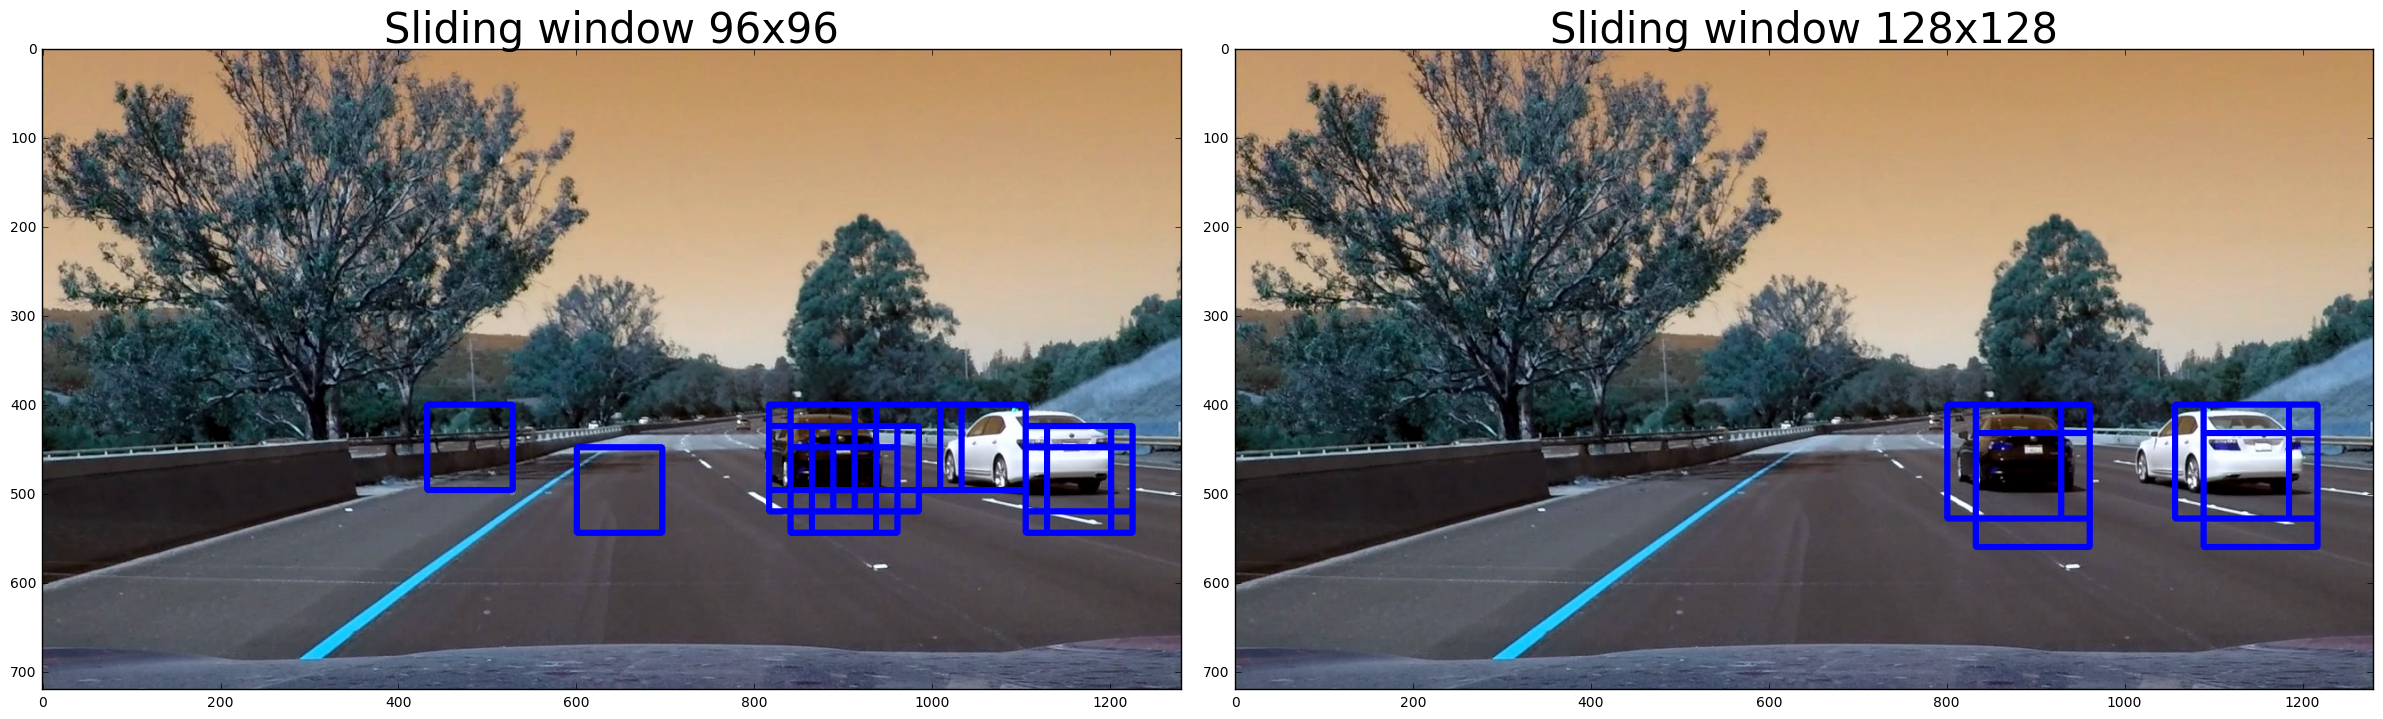

In [12]:
# implement sliding windows on test image

image = cv2.imread('test_images/test6.jpg')
copy_image = np.copy(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

window_img1 = draw_boxes(copy_image, hot_windows, color=(0, 0, 255), thick=6)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

window_img2 = draw_boxes(copy_image, hot_windows, color=(0, 0, 255), thick=6)



# display results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  
f.tight_layout()

ax1.imshow(window_img1)
ax1.set_title('Sliding window 96x96', fontsize=30)
ax2.imshow(window_img2)
ax2.set_title('Sliding window 128x128', fontsize=30)

print("END processing......", time.strftime("%c"))

In [14]:
# Run
# more functions

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


print("END processing......", time.strftime("%c"))

END processing...... Sat Apr 22 17:03:17 2017


END processing...... Sat Apr 22 17:03:29 2017


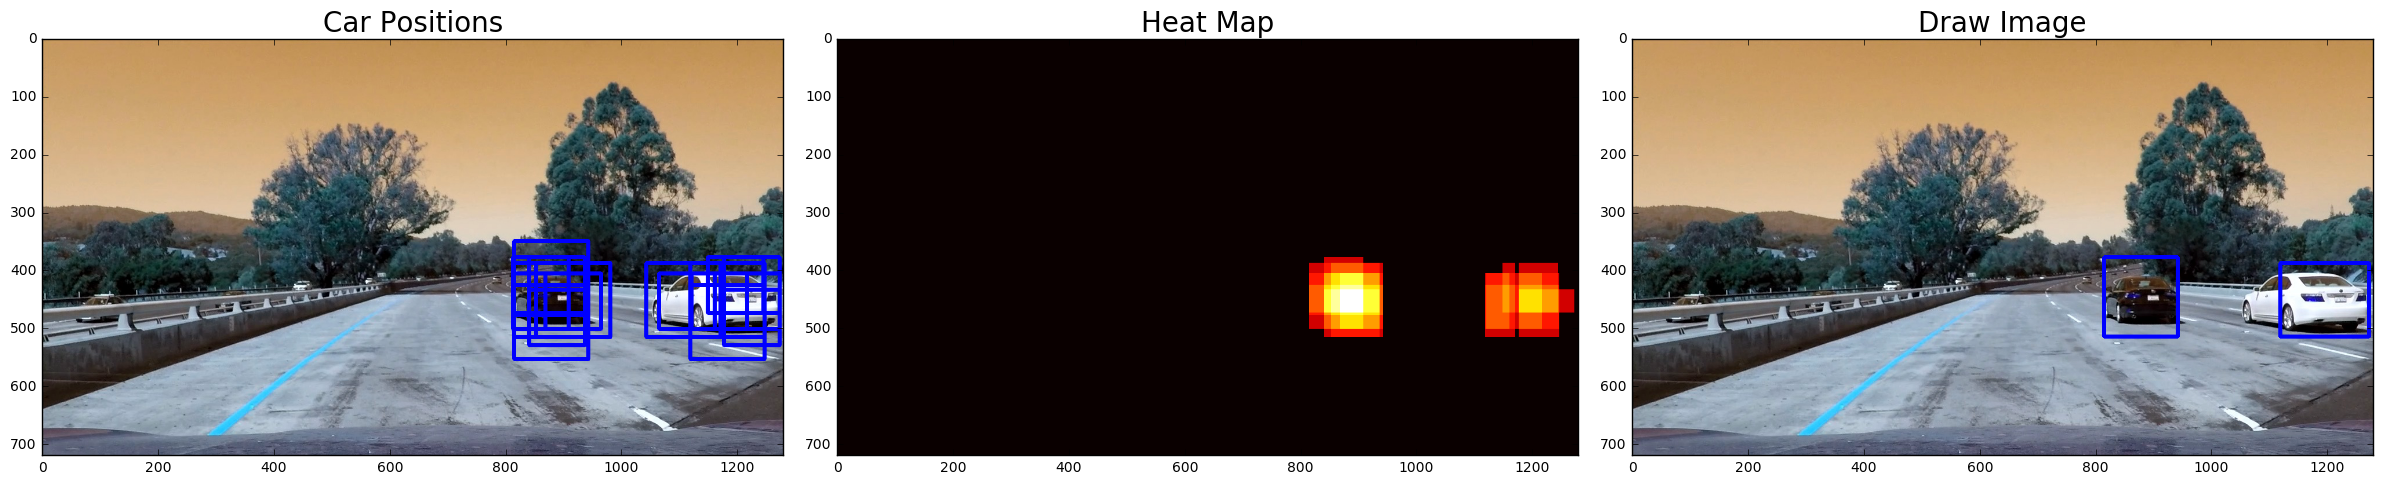

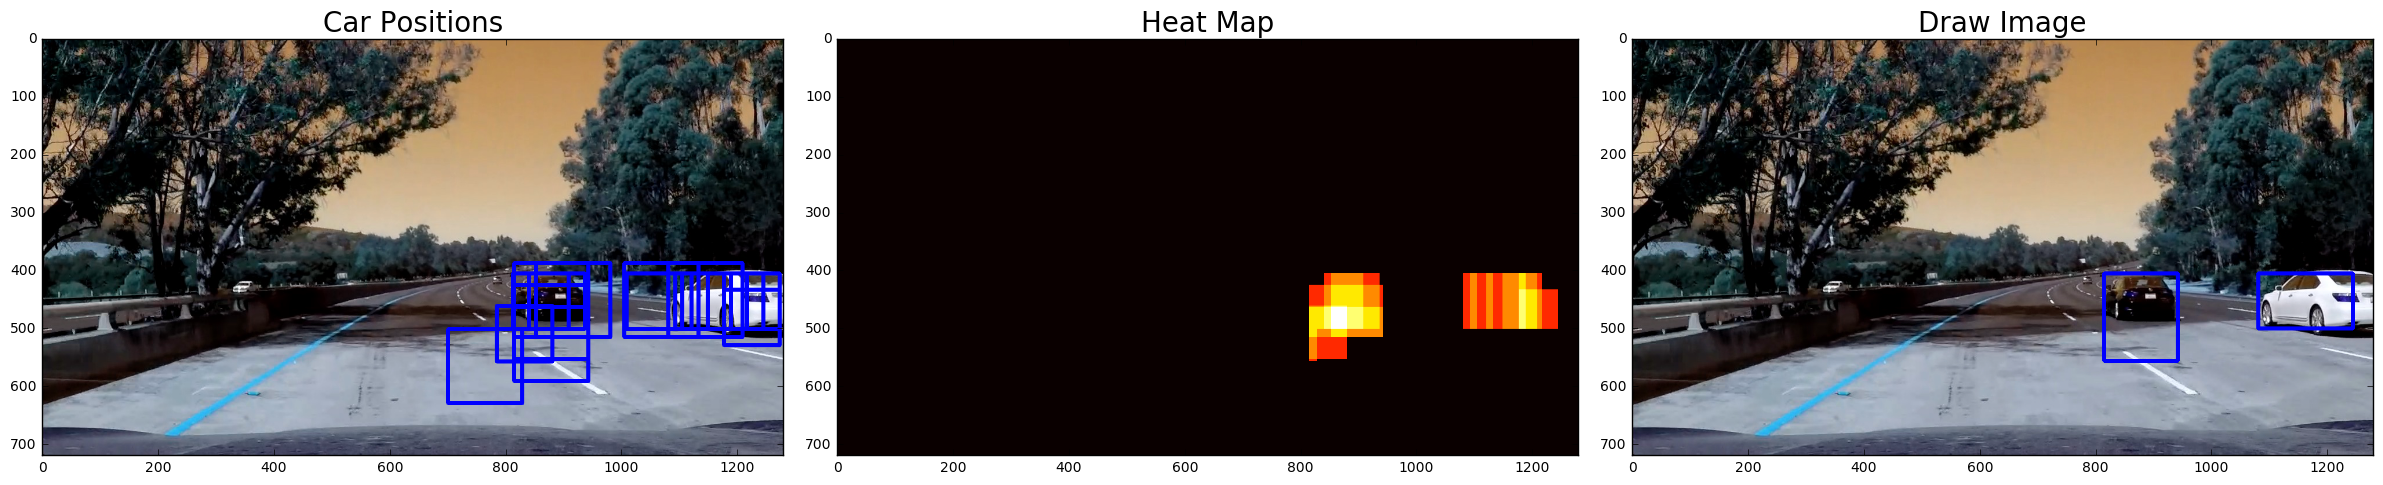

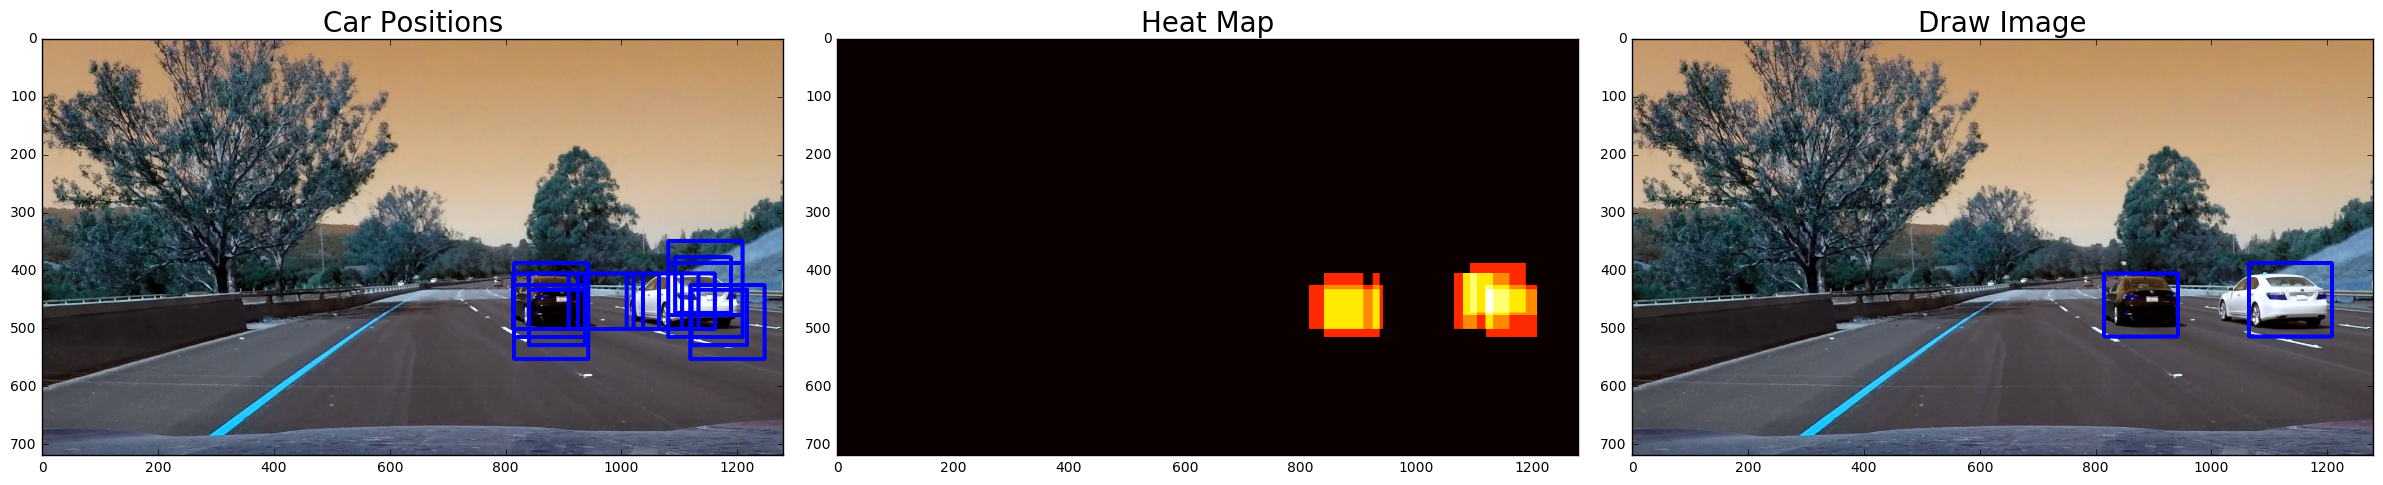

In [15]:
# Test performance of Classifier on sample images

files = ['test_images/test1.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']
for file in files:
    image = cv2.imread(file)
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    xy_window = [(96,96),(128,128)]
    y_start_stop = [[350, 600], [350, None]]

    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.7, 0.7))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 1 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()

    hot_windows = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)     
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(window_img)
    ax1.set_title('Car Positions', fontsize=20)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map', fontsize=20)
    ax3.imshow(draw_img )
    ax3.set_title('Draw Image', fontsize=20)
    
print("END processing......", time.strftime("%c"))

In [16]:
# run
# Function for video pipeline implementation

def add_windows(input_image, windows, classifier, scaler, draw=True):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """
    #global hot_windows_list
    xy_window = [(96,96), (128,128), (256,256)]
    y_start_stop = [[400, 650], [400, None], [400, None]]
    
    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.7, 0.7))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 16 # HOG pixels per cell
    cell_per_block = 1 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()


    hot_windows = search_windows(input_image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
   

    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img
    
    return hot_windows

print ("end processing", time.strftime("%c"))

end processing Sat Apr 22 17:03:43 2017


In [17]:
# Run
# Process images for the video file 
def process_image(image, n_frames=20, threshold=22):  
     
    hot_windows_temp =[]
    global hot_windows_list
    global windows
    global hot_windows_final
   
    windows = add_windows(image, windows, svc, X_scaler, draw=False)
    hot_windows_list.append(windows)
   
    if len(hot_windows_list) <= n_frames:
         hot_windows_final = sum(hot_windows_list, []) # Add windows from all available frames
    
    #Look at last n frames and append all hot windows found
    else: 
        for val in hot_windows_list[(len(hot_windows_list) - n_frames -1) : (len(hot_windows_list)-1)]:
            hot_windows_temp.append(val)
    #Flatten this list
        hot_windows_final = sum(hot_windows_temp, [])
    
    
    #Create a frame_heatmap
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    frame_heatmap = add_heat(frame_heatmap, hot_windows_final)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    # plt.imshow(draw_img)
    return draw_img

print ("end processing", time.strftime("%c"))

end processing Sat Apr 22 17:03:50 2017


In [18]:
# Run
# Video file - create 

from moviepy.editor import VideoFileClip
from IPython.display import HTML

hot_windows_list = []

output = 'video_v2.mp4'
clip1 = VideoFileClip('project_video.mp4')
out_clip = clip1.fl_image(process_image) 

%time out_clip.write_videofile(output, audio=False)


print ("end processing", time.strftime("%c"))

[MoviePy] >>>> Building video video_v2.mp4
[MoviePy] Writing video video_v2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:42<00:00,  1.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_v2.mp4 

Wall time: 12min 43s
end processing Sat Apr 22 17:16:45 2017
